# Cuda setup
Check if cuda is available.

In [357]:
import torch
import numpy as np

# check if CUDA is available
train_on_gpu = torch.cuda.is_available()

if not train_on_gpu:
    print('CUDA is not available.  Training on CPU ...')
else:
    print('CUDA is available!  Training on GPU ...')

CUDA is available!  Training on GPU ...


# Import data from source
METHOD 1: install yfinance in the environment hosting python and jupyter. I used Anaconda, and installed through conda terminal into my environment.

*pip install yfinance*

Use the yfinance API to retrieve company data

In [358]:
# yahoo finance api to collect stock data
import yfinance as yf
import os

# datetime imports to work with dates
from datetime import date
from dateutil.relativedelta import relativedelta

# alpaca api to collect stock data
from alpaca_trade_api.rest import REST, TimeFrame, TimeFrameUnit

# Process data from csv files
Use pandas library for processing files

Use matplotlib to display graphs and visualizations.

Use torch to create and train a RNN model.

In [359]:
import pandas as pd
import torch.nn as nn
import matplotlib.pyplot as plt
import torch.optim as optim

from torchvision import datasets
import torchvision.transforms as transforms
from torch.utils.data.sampler import SubsetRandomSampler
import torch.optim.lr_scheduler as lr_scheduler
%matplotlib inline

In [360]:
#Change directory for Lorne's jupyter notebook
# I am mixing windows and wsl on windows so I need to manaually change the directory, so you won't need to when you run it
if True:
    # See files in current directory
    import os

    current_directory = os.getcwd()
    print(current_directory)

    entries = os.listdir('.')
    files = [entry for entry in entries if os.path.isfile(entry)]

    for file_name in files:
        print(file_name)

    %cd "/mnt/c/Users/LPC/Documents/GitHub/CSCI611-NNSTOCKS"

    current_directory = os.getcwd()
    print(current_directory)

    entries = os.listdir('.')
    files = [entry for entry in entries if os.path.isfile(entry)]

    # Print the names of the files
    for file_name in files:
        print(file_name)

/mnt/c/Users/LPC/Documents/GitHub/CSCI611-NNSTOCKS
AAPL_intraday.csv
AAPL_intraday1.csv
AMD_intraday.csv
AMD_intraday1.csv
first_try.ipynb
model_trained.pt
README.md
RNN (0721 Normalization).ipynb
RNN.ipynb
/mnt/c/Users/LPC/Documents/GitHub/CSCI611-NNSTOCKS
/mnt/c/Users/LPC/Documents/GitHub/CSCI611-NNSTOCKS
AAPL_intraday.csv
AAPL_intraday1.csv
AMD_intraday.csv
AMD_intraday1.csv
first_try.ipynb
model_trained.pt
README.md
RNN (0721 Normalization).ipynb
RNN.ipynb


# Helper functions
StockDataset class to hold pytorch data

In [361]:
#HYPERPARAMETER
training_percentage = 6
#HYPERPARAMETER
valid_percentage = 2
#HYPERPARAMETER
testing_percentage = 2
class StockDataset(torch.utils.data.Dataset[float]):
    def __init__(self, sequences, targets):
        super(StockDataset).__init__()
        self.sequences = sequences
        self.targets = targets
    def __len__(self):
        return len(self.sequences)    
    def __getitem__(self, index):
        sequence = torch.tensor(self.sequences[index], dtype=torch.float32).unsqueeze(-1)#sequence at index 
        target = torch.tensor(self.targets[index], dtype=torch.float32)#test_value at index
        return sequence, target
        
class RNN(nn.Module):
    def __init__(self, input_size=1, hidden_size=128, num_layers=2, nonlinearity='tanh', bias=True, batch_first=True, dropout=0.0):
        super(RNN, self).__init__()
        self.dropout = nn.Dropout(p=0.5)
        self.rnn = nn.RNN(input_size=input_size, hidden_size=hidden_size, num_layers=num_layers, nonlinearity=nonlinearity, bias=bias, 
            batch_first=batch_first, dropout=dropout, bidirectional=False, device=None, dtype=None)
        self.fc = nn.Linear(128, 1)
        
    def forward(self, x):
        self.dropout(x)
        self.output, self.hidden = self.rnn(x)
        prediction = self.fc(self.output[:, -1, :])
        return prediction.squeeze(-1)

# get_yahoo_stock_data(name, interval="5m", period="7d")

unction that calls yfinance to get stock data from a defined time period

@params stock_name: name of the stock to get data for

@params interval: interval of the data, default is 15 minutes

@params months: number of months to get data for

In [362]:
# Generate stock price data from yahoo finance 
def get_yahoo_stock_data(name, interval="5m", period="7d"):
    data = yf.download(name, interval=interval, period=period)
    return data

# get_alpaca_stock_data(name, interval="15", months="6") 

function calls alpaca api to get stock data for a defined time period starting from June 1st 2021

@params stock_name: name of the stock to get data for

@params interval: interval of the data, default is 15 minutes

@params months: number of months to get data for

In [363]:
# Generate stock price data from alpaca
def get_alpaca_stock_data(name, interval="15", months="6"):
    name_of_file = name + "_intraday1.csv"

    start_date = date(2021, 6, 1)
    end_date = start_date + relativedelta(months=int(months))  # Adds months

    api = REST('PKJ41QP5QU0TYS4S1BYB', 'o5HVFGx0XWSMoMyeQdRJwG1apYXtuMNcguWpjqqe')

    data = api.get_bars(name, TimeFrame(int(interval), TimeFrameUnit.Minute), start_date, end_date, adjustment='raw').df

    data = data.rename(columns={"close": "Close", "open": "Price", "high": "High", "low": "Low", "volume": "Volume", "datetime": "Datetime", "ticker": "Ticker"})

    data.to_csv(name_of_file)

    return name_of_file

# plot_loss(training_loss_array, validation_loss_array, epochs)

Creates a matplotlib plot of the training and validation loss

@params training_loss_array: Array of training loss values

@params validation_loss_array: Array of validation loss values

@params epochs: Number of epochs

In [364]:
# Creates a matplotlib plot of the training and validation loss
def plot_loss(training_loss_array, validation_loss_array, epochs):
    # Create the plot
    plt.figure(figsize=(10, 6))

    # Plot training loss
    plt.plot(range(1, int((epochs)/10) + 1), training_loss_array, marker='o', linestyle='-', color='b', label='Training Loss')

    # Plot validation loss
    plt.plot(range(1, int((epochs)/10) + 1), validation_loss_array, marker='x', linestyle='--', color='r', label='Validation Loss')

    # Add title and labels
    plt.title('Training vs Validation Loss Over Epochs')
    plt.xlabel('Number of Epochs')
    plt.ylabel('Loss')

    # Add grid and legend
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.legend()

    # Add x-axis ticks
    plt.xticks(range(1, (int((epochs + 1)/10)+1), 1))

    # Show the plot
    plt.show()

# plot_target_vs_predicted_values(target_values_array, predicted_values_array, batch_size)

Creates a matplotlib plot of the target values vs the predicted values.

@params target_values_array: Array of actual real values of selected stock for testing phase of RNN

@params predicted_values_array: Array of predicted values generated by RNN

@params batch_size: Number of values in target_values_array and predicted_values_array

In [365]:
# Creates a matplotlib plot of the training and validation loss
def plot_target_vs_predicted_values(target_values_array, predicted_values_array, batch_size):
    # Create the plot
    plt.figure(figsize=(10, 6))

    # Plot target values
    plt.plot(range(1, batch_size + 1), target_values_array, marker='o', linestyle='-', color='b', label='Target Values')

    # Plot predicted values
    plt.plot(range(1, batch_size + 1), predicted_values_array, marker='x', linestyle='--', color='r', label='Predicted Values')

    # Add title and labels
    plt.title('Target vs Predicted Stock Values')
    plt.xlabel('Time')
    plt.ylabel('Stock Value')

    # Add grid and legend
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.legend()

    # Add x-axis ticks
    plt.xticks(range(1, batch_size, 1))

    # Show the plot
    plt.show()

# standardize_2d(data)

Standardize the data in a 2D array feed to RNN. It standardizes the data by subtracting the mean and dividing by the standard deviation.

@params data: 2D array of data to be standardized

@returns: Standardized 2D array

In [366]:
def standardize_2d(data):
    # Get the average
    average_val = np.mean(data)

    # Get the standard deviation
    std_val = np.std(data)

    # Subtract the average and divide by the standard deviation
    standardized_data = (data - average_val) / std_val
    return standardized_data

# Display relevant information for formatting purposes

In [367]:
class RNN_initializer:
    #HYPERPARAMETER
    def __init__(self, retrieve, name, recomp, nval, ival, pval, sequence_len, batch_size, num_workers, epochs, learning_rate, lr_scheduler_rate, beta1, beta2):
        self.batch_size = batch_size
        self.num_workers = num_workers
        self.learning_rate = learning_rate
        self.lr_scheduler_rate = lr_scheduler_rate
        self.beta1 = beta1
        self.beta2 = beta2

        # Get stock data
        if(retrieve == True): # Retrieve means we call the api calls to get the stock data again. Its computationaly expensive so we don't always retrieve the stock data
            if (stock_data_source == "yahoo"):
                self.csv_name = self.retrieve_csv(name, recomp, nval, str(ival[0])+ival[1], str(pval[0])+pval[1])
            else:
                self.csv_name = get_alpaca_stock_data(name, stock_interval, stock_period)
        else:
            self.csv_name = name

        # We read the CSV createed from the Stock API functions     
        self.df=pd.read_csv(name + "_intraday1.csv")
        #format data, and prepare it for RNN
        if(stock_data_source == "yahoo"):
            price = self.df['Close'].to_list()[2:]
            self.axis_labels = self.df['Price'].to_list()[2:]
        else:
            price = self.df['Close'].to_list()[1:]
            self.axis_labels = self.df['Price'].to_list()[1:]
        date_format_with_time = "%Y-%m-%d %H:%M:%S"

        # Input the data 
        price_inputs = [float(x) for x in price]
        
        # Standardize the data by subtracting the mean of the data and dividing by the standard deviation of the data
        price_inputs = standardize_2d(price_inputs)
        sequence_length = sequence_len
        #Training sets
        train_seq = []
        train_tar = []
        #Validation sets
        valid_seq = []
        valid_tar = []
        #Testing sets
        test_seq = []
        test_tar = []

        # Choose a selected time range
        #HYPERPARAMETERS
        train_range = (len(price_inputs)//10 * training_percentage)
        valid_range_beg = train_range
        valid_range_end = train_range + (len(price_inputs)//10 * valid_percentage)
        test_range_beg = valid_range_end
        test_range_end = valid_range_end + (len(price_inputs)//10 * testing_percentage)
        
        # Generate sequences and targets list for loading data
        for i in range(train_range - sequence_length):
            seq = price_inputs[i:i+sequence_length]
            train_seq.append(seq)
            temp = price_inputs[i+sequence_length]
            train_tar.append(temp)
        for j in range(valid_range_beg, valid_range_end-sequence_length):
            seq = price_inputs[j:j+sequence_length]
            valid_seq.append(seq)
            temp = price_inputs[j+sequence_length]
            valid_tar.append(temp)
        for k in range(test_range_beg, test_range_end-sequence_length):
            seq = price_inputs[k:k+sequence_length]
            test_seq.append(seq)
            temp = price_inputs[k+sequence_length]
            test_tar.append(temp)
        train_data = StockDataset(train_seq, train_tar)
        valid_data = StockDataset(valid_seq, valid_tar)
        test_data = StockDataset(test_seq, test_tar)
        
        # Load training, validation, and testing data
        self.train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, num_workers=num_workers)
        self.valid_loader = torch.utils.data.DataLoader(valid_data, batch_size=batch_size, num_workers=num_workers)
        self.test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, num_workers=num_workers)
    
    # retreive_csv is a file that allows the user to extract stock data from yahoo finance.
    # @param: name, name of file
    # @param: recomp, indicates if file needs to be recompiled
    # @param: num, indicates which file need to be recompiled
    def retrieve_csv(self, name, recomp, nval, ival, pval):
        # Example: Get 1-minute intraday data for Apple (AAPL) for 1 day
        data = get_yahoo_stock_data(stock_name, stock_interval, stock_period)
        ext = ".csv"
        pt2 = "_intraday"
        num = 1
        file_name = name + pt2 + str(num) + ext
        found = False
        if(recomp!=True):
            while(found!=True):
                if os.path.isfile(file_name):
                    num+=1
                    file_name = name + pt2 + str(num) + ext
                else:
                    found = True
        else:
            if(nval >= 1):
                file_name = name + pt2 + str(nval) + ext
            else:
                file_name = name + pt2 + ext
        data.to_csv(file_name)
        return file_name

    def display_fig(self):
        plt.figure(figsize=(20, 20))
        plt.title(name + " Intraday Stock Price")
        plt.plot(self.axis_labels, self.price_inputs)
        plt.xlabel("time")
        plt.ylabel("price")
        plt.xticks(self.axis_labels[::26])
        plt.yticks(self.price_inputs[::30])
        plt.show()

    def show_df_info(self):
        self.df.head(15)
        self.df.tail(10)
        print("Row count: " + str(len(self.df)))
    def init_RNN(self):
        rnn = RNN()
        return rnn
    def trainAndTest(self, rnn):
        #RNN model
        # move tensors to GPU if CUDA is available
        min_loss = np.inf

        if train_on_gpu:
            rnn.cuda()
        # Use MSELoss instead of MSEAbsoluteLoss (predicting next price compared to next change)
        error = nn.MSELoss()
        # Specify optimizer
        optimizer = torch.optim.Adam(rnn.parameters(), lr=self.learning_rate, betas=(beta1, beta2))
        #optimizer = optim.SGD(model.parameters(), lr=0.01)
        #self.price_tensor = torch.tensor(self.sequences, dtype=torch.float32).unsqueeze(-1)#input 
        #self.y_tensor = torch.tensor(self.test_vals, dtype=torch.float32)#test_values
        
        # Learning rate scheduler, decreases over time
        scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=self.lr_scheduler_rate, patience=10)
        
        # Variable to keep track of the minimum validation loss
        valid_loss_min = np.inf

        # Training loop
        for epoch in range(epochs):
            train_loss = 0.0
            valid_loss = 0.0
            #TRAINING
            rnn.train()
            for batch_idx, (data, target) in enumerate(self.train_loader):
                # Move tensors to GPU if CUDA is available
                if train_on_gpu:
                    data, target = data.cuda(), target.cuda()
                # Clear the gradients of all optimized variables
                optimizer.zero_grad()
                # Forward pass: compute predicted outputs by passing inputs to the model
                output = rnn(data)
                # Calculate the batch loss
                loss_train = error(output, target)
                # Backward pass: compute gradient of the loss with respect to model parameters
                loss_train.backward()
                # Perform a single optimization step (parameter update)
                optimizer.step()
                train_loss += loss_train.item()*data.size(0)
                if (loss_train < min_loss):
                    min_loss = loss_train
                    #torch.save(rnn.state_dict(), "rnn.pth")

            # Update learning rate
            scheduler.step(train_loss)  

    
            ######################    
            # validate the model #
            ######################
            rnn.eval()
            for batch_idx, (data, target) in enumerate(self.valid_loader):
                # Move tensors to GPU if CUDA is available
                if train_on_gpu:
                    data, target = data.cuda(), target.cuda()
                # Forward pass: compute predicted outputs by passing inputs to the model
                output = rnn(data)
                # Calculate the batch loss
                loss_valid = error(output, target)
                # Perform a single optimization step (parameter update)
                valid_loss += loss_valid.item()*data.size(0)
                if (loss_valid < min_loss):
                    min_loss = loss_valid
                    #torch.save(rnn.state_dict(), "rnn.pth")

            # Calculate average losses
            train_loss = train_loss/len(self.train_loader.dataset)
            valid_loss = valid_loss/len(self.valid_loader.dataset)
            # Save model if validation loss has decreased
            if valid_loss <= valid_loss_min and (epoch+1) % 10 == 0:
                print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
                valid_loss_min,
                valid_loss))
                torch.save(rnn.state_dict(), 'model_trained.pt')
                valid_loss_min = valid_loss

            # Print training and validation loss every 10 epochs
            elif (epoch) % 10 == 0:
                lr = optimizer.param_groups[0]["lr"]
                print(f"Epoch {epoch+1}/{epochs}, Training Loss: {loss_train.item():.6f}, Validation Loss: {loss_valid.item():.6f}")
                training_loss_array.append(float(loss_train.item()))
                validation_loss_array.append(float(loss_valid.item()))
        
        # Return the minimum loss
        return min_loss
        


In [368]:
# Stock variables used when collecting stock data

# Choose which api to use to grab stock data, either "yahoo" or "alpaca"
stock_data_source = "alpaca"
sequence_len = 4
# Loss array used to store loss values for each 10 epochs, reset each set of hyperparameters
training_loss_array = []
validation_loss_array = []
test_loss = np.inf

#HYPERPARAMETER
# Stock variables when using yahoo finance api
if stock_data_source == "yahoo":
    stock_name = "AMD"
    stock_interval="5m"
    stock_period="7d"
    epochs = 100
    lr_scheduler_rate = 0.8
    beta1 = 0.9
    beta2 = 0.999

#HYPERPARAMETER
# Stock variables when using alpaca api
if stock_data_source == "alpaca":
    stock_name = "AMD"
    stock_interval="15"
    stock_period="12" #months
    epochs = 150
    lr_scheduler_rate = 0.1
    beta1 = 0.9
    #changed
    #beta1 = 0.95
    beta2 = 0.999

batch_size = 16
num_workers = 0

# Setting up control

In [369]:
rnnControlSetup = RNN_initializer(retrieve=True, name=stock_name, recomp=True, nval=1, ival=[5, "m"], 
    pval=[7,"d"], sequence_len=sequence_len, batch_size=16, num_workers=0, epochs=150, learning_rate=0.001, 
    lr_scheduler_rate=0.1, beta1=0.95, beta2=0.999)
rnnControl = rnnControlSetup.init_RNN()

# Test the lr change

In [370]:
# Will skip this training process if set to True
skip_this_step = True

if not skip_this_step:
    #Test various learning rates
    learning_rate_list = [0.005, 0.001, 0.0005, 0.0001, 0.00005, 0.00001] 
    best_lr = [[np.inf, np.inf] , [np.inf, np.inf]] # Record two pairs of [loss, learning rate] to tune learning rate later
    best_lr_in_loop = np.inf # Capture best learning rate in the loop
    repeated_loops_per_lr = 1 # Number of times to repeat the loop for each learning rate
    bestRNN_Setup = [rnnControlSetup,None] # To hold best RNN model
    bestRNN = [rnnControl,None] # To hold best RNN model
    bestRNN_in_loop = rnnControl

    # Loop through learning rates
    for lr in learning_rate_list:
        print("\n\n-------------------------------------------------------------------------------")
        print("Learning rate: ", lr, "   Loop: ", repeated_loops_per_lr)
        print(stock_name, "Time interval ", stock_interval, "min", "Time period: ", stock_period, 'months')
        print("Batch size: ", batch_size, "Number of workers: ", num_workers, "Epochs: ", epochs)
        print("Learning rate scheduler rate: ", lr_scheduler_rate)
        print("Beta1: ", beta1, "Beta2: ", beta2)
        print("-------------------------------------------------------------------------------")
        rnnSetup = RNN_initializer(retrieve=False, name=stock_name, recomp=True, nval=1, ival=[5, "m"], pval=[7,"d"], batch_size=batch_size, num_workers=num_workers, epochs=epochs, learning_rate=lr, lr_scheduler_rate=lr_scheduler_rate, beta1=beta1, beta2=beta2)
        for i in range(repeated_loops_per_lr):
            rnn = rnnSetup.init_RNN()
            # Reset loss arrays if repeated_loops_per_lr > 1
            training_loss_array = []
            validation_loss_array = []

            # Train and test the RNN
            loss = rnnSetup.trainAndTest(rnn)

            # Update best learning rate if current loss is lower
            if best_lr_in_loop > loss:
                best_lr_in_loop = loss
                bestRNN_in_loop = rnn

        # If found best lr, remove worst lr from list
        if best_lr_in_loop < best_lr[0][0]:
            best_lr[1] = best_lr[0]
            best_lr[0] = [best_lr_in_loop, lr]
            bestRNN[1] = bestRNN[0]
            bestRNN[0] = bestRNN_in_loop
            bestRNN_Setup[1] =  bestRNN_Setup[0] 
            bestRNN_Setup[0] =  rnnSetup
        # If current loss is better than second best, update second best
        elif best_lr_in_loop < best_lr[1][0]:
            best_lr[1] = [best_lr_in_loop, lr]
            bestRNN[1] = bestRNN_in_loop
            bestRNN_Setup[1] =  rnnSetup

        # Reset best lr in loop for next iteration    
        best_lr_in_loop = np.inf

        # Plot training and validation loss calculated for current learning rate during rnn.trainAndTest()
        plot_loss(training_loss_array, validation_loss_array, epochs)

    print("\n\nBest learning rate: ", best_lr[0][1], "   Loss: ", best_lr[0][0])
    print("Second best learning rate: ", best_lr[1][1], "   Loss: ", best_lr[1][0])

skip_this_step = False

# Test beta1 value effect



-------------------------------------------------------------------------------
Learning rate:  0.001    Loop:  1
AMD Time interval  15 min Time period:  12 months
Batch size:  16 Number of workers:  0 Epochs:  150
Learning rate scheduler rate:  0.1
Beta1:  0.45 Beta2:  0.999
-------------------------------------------------------------------------------
Epoch 1/150, Training Loss: 0.017779, Validation Loss: 0.220678
Validation loss decreased (inf --> 0.006361).  Saving model ...
Epoch 11/150, Training Loss: 0.006034, Validation Loss: 0.002418
Epoch 21/150, Training Loss: 0.011487, Validation Loss: 0.001877
Validation loss decreased (0.006361 --> 0.004028).  Saving model ...
Epoch 31/150, Training Loss: 0.007228, Validation Loss: 0.001136
Validation loss decreased (0.004028 --> 0.002779).  Saving model ...
Epoch 41/150, Training Loss: 0.004867, Validation Loss: 0.000772
Validation loss decreased (0.002779 --> 0.002281).  Saving model ...
Epoch 51/150, Training Loss: 0.003644, Validat

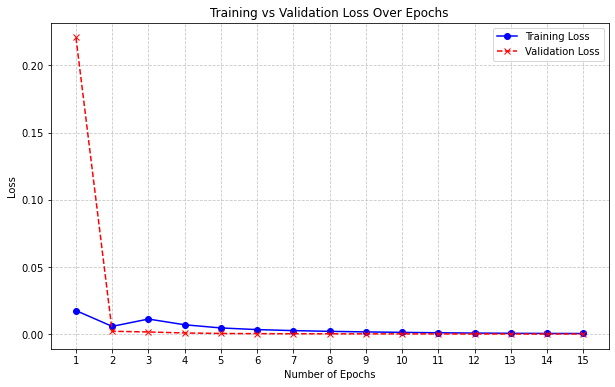



-------------------------------------------------------------------------------
Learning rate:  0.001    Loop:  1
AMD Time interval  15 min Time period:  12 months
Batch size:  16 Number of workers:  0 Epochs:  150
Learning rate scheduler rate:  0.1
Beta1:  0.7 Beta2:  0.999
-------------------------------------------------------------------------------
Epoch 1/150, Training Loss: 0.016525, Validation Loss: 0.154181
Validation loss decreased (inf --> 0.004612).  Saving model ...
Epoch 11/150, Training Loss: 0.005242, Validation Loss: 0.001189
Epoch 21/150, Training Loss: 0.012861, Validation Loss: 0.001967
Validation loss decreased (0.004612 --> 0.004592).  Saving model ...
Epoch 31/150, Training Loss: 0.008243, Validation Loss: 0.001372
Validation loss decreased (0.004592 --> 0.003093).  Saving model ...
Epoch 41/150, Training Loss: 0.005501, Validation Loss: 0.000969
Validation loss decreased (0.003093 --> 0.002467).  Saving model ...
Epoch 51/150, Training Loss: 0.004096, Validati

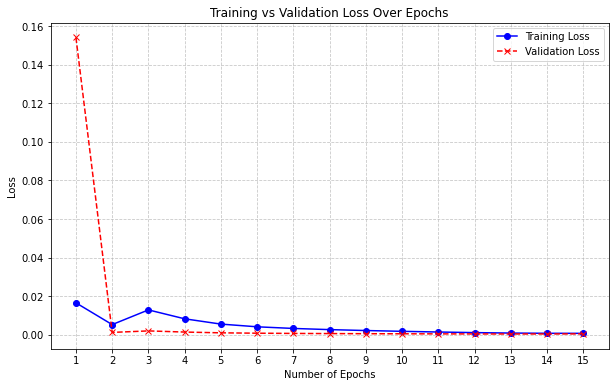



-------------------------------------------------------------------------------
Learning rate:  0.001    Loop:  1
AMD Time interval  15 min Time period:  12 months
Batch size:  16 Number of workers:  0 Epochs:  150
Learning rate scheduler rate:  0.1
Beta1:  0.9 Beta2:  0.999
-------------------------------------------------------------------------------
Epoch 1/150, Training Loss: 0.015681, Validation Loss: 0.182303
Validation loss decreased (inf --> 0.004743).  Saving model ...
Epoch 11/150, Training Loss: 0.005179, Validation Loss: 0.001306
Epoch 21/150, Training Loss: 0.011119, Validation Loss: 0.002321
Validation loss decreased (0.004743 --> 0.004262).  Saving model ...
Epoch 31/150, Training Loss: 0.007289, Validation Loss: 0.001395
Validation loss decreased (0.004262 --> 0.002990).  Saving model ...
Epoch 41/150, Training Loss: 0.005121, Validation Loss: 0.000989
Validation loss decreased (0.002990 --> 0.002389).  Saving model ...
Epoch 51/150, Training Loss: 0.003876, Validati

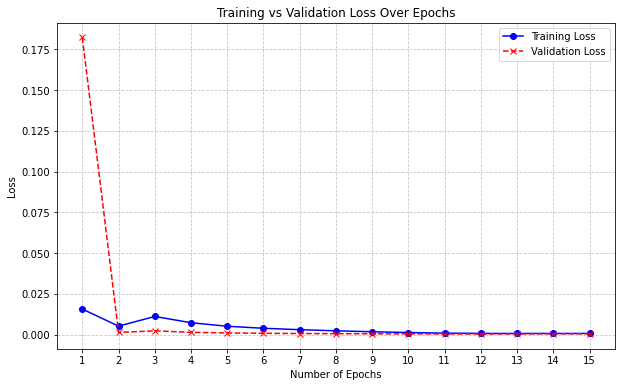



-------------------------------------------------------------------------------
Learning rate:  0.001    Loop:  1
AMD Time interval  15 min Time period:  12 months
Batch size:  16 Number of workers:  0 Epochs:  150
Learning rate scheduler rate:  0.1
Beta1:  0.95 Beta2:  0.999
-------------------------------------------------------------------------------
Epoch 1/150, Training Loss: 0.020253, Validation Loss: 0.246325
Validation loss decreased (inf --> 0.006389).  Saving model ...
Epoch 11/150, Training Loss: 0.006003, Validation Loss: 0.002446
Epoch 21/150, Training Loss: 0.012690, Validation Loss: 0.001413
Validation loss decreased (0.006389 --> 0.004135).  Saving model ...
Epoch 31/150, Training Loss: 0.007794, Validation Loss: 0.001043
Validation loss decreased (0.004135 --> 0.002855).  Saving model ...
Epoch 41/150, Training Loss: 0.005134, Validation Loss: 0.000792
Validation loss decreased (0.002855 --> 0.002312).  Saving model ...
Epoch 51/150, Training Loss: 0.003801, Validat

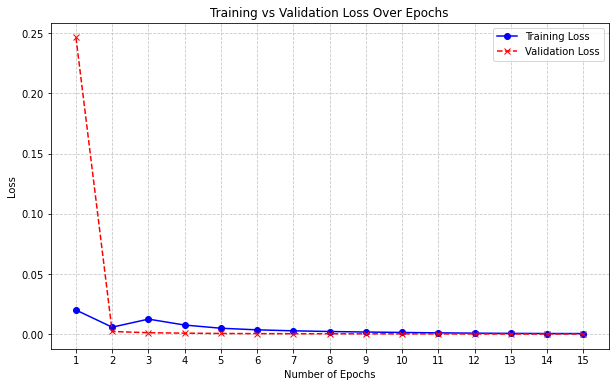



-------------------------------------------------------------------------------
Learning rate:  0.001    Loop:  1
AMD Time interval  15 min Time period:  12 months
Batch size:  16 Number of workers:  0 Epochs:  150
Learning rate scheduler rate:  0.1
Beta1:  0.99 Beta2:  0.999
-------------------------------------------------------------------------------
Epoch 1/150, Training Loss: 0.016638, Validation Loss: 0.187057


In [ ]:

skip_this_step = False

if not skip_this_step:
    #test various learning rates
    beta1_list = [0.45, 0.7, 0.9, 0.95, 0.99, 1]
    best_beta1 = [[np.inf, np.inf] , [np.inf, np.inf]] #record two pairs of [loss, learning rate] to tune learning rate later
    best_beta1_in_loop = np.inf
    repeated_loops_per_beta1 = 1
    bestRNN_Setup = [rnnControlSetup,None]
    bestRNN = [rnnControl,None]
    bestRNN_in_loop = rnnControl
    #lr testing
    for b1 in beta1_list:
        print("\n\n-------------------------------------------------------------------------------")
        print("Learning rate: ", 0.001, "   Loop: ", repeated_loops_per_beta1)
        print(stock_name, "Time interval ", stock_interval, "min", "Time period: ", stock_period, 'months')
        print("Batch size: ", batch_size, "Number of workers: ", num_workers, "Epochs: ", epochs)
        print("Learning rate scheduler rate: ", lr_scheduler_rate)
        print("Beta1: ", b1, "Beta2: ", beta2)
        print("-------------------------------------------------------------------------------")
        rnnSetup = RNN_initializer(retrieve=False, name=stock_name, recomp=True, nval=1, ival=[5, "m"], pval=[7,"d"], 
                sequence_len=sequence_len, batch_size=batch_size, num_workers=num_workers, epochs=epochs, learning_rate=lr, 
                lr_scheduler_rate=lr_scheduler_rate, beta1=b1, beta2=beta2)
        for i in range(repeated_loops_per_beta1):
            rnn = rnnSetup.init_RNN()
            #returns
            training_loss_array = []
            validation_loss_array = []
            loss = rnnSetup.trainAndTest(rnn)
            if best_beta1_in_loop > loss:
                best_beta1_in_loop = loss
                bestRNN_in_loop = rnn
        #if found best lr, remove worst lr from list
        if best_beta1_in_loop < best_beta1[0][0]:
            best_beta1[1] = best_beta1[0]
            best_beta1[0] = [best_beta1_in_loop, b1]
            bestRNN[1] = bestRNN[0]
            bestRNN[0] = bestRNN_in_loop
            bestRNN_Setup[1] =  bestRNN_Setup[0] 
            bestRNN_Setup[0] =  rnnSetup
            #if 
        elif best_beta1_in_loop < best_beta1[1][0]:
            best_beta1[1] = [best_beta1_in_loop, b1]
            bestRNN[1] = bestRNN_in_loop
            bestRNN_Setup[1] =  bestRNN_Setup[1]
        best_beta1_in_loop = np.inf

        plot_loss(training_loss_array, validation_loss_array, epochs)

    print("\n\nBest beta1: ", best_beta1[0][1], "   Loss: ", best_beta1[0][0])
    print("Second best beta1: ", best_beta1[1][1], "   Loss: ", best_beta1[1][0])

# Test beta2 value effect

In [ ]:
skip_this_step = False
if not skip_this_step:
    #test various learning rates
    beta2_list = [0.5, 0.9, 0.99, 0.999, 0.9999, 1]
    best_beta2 = [[np.inf, np.inf] , [np.inf, np.inf]] #record two pairs of [loss, learning rate] to tune learning rate later
    best_beta2_in_loop = np.inf
    repeated_loops_per_beta2 = 1
    bestRNN_Setup = [rnnControlSetup,None]
    bestRNN = [rnnControl,None]
    bestRNN_in_loop = rnnControl
    #lr testing
    for b2 in beta2_list:
        print("\n\n-------------------------------------------------------------------------------")
        print("Learning rate: ", 0.001, "   Loop: ", repeated_loops_per_beta2)
        print(stock_name, "Time interval ", stock_interval, "min", "Time period: ", stock_period, 'months')
        print("Batch size: ", batch_size, "Number of workers: ", num_workers, "Epochs: ", epochs)
        print("Learning rate scheduler rate: ", lr_scheduler_rate)
        print("Beta1: ", beta1, "Beta2: ", b2)
        print("-------------------------------------------------------------------------------")
        rnnSetup = RNN_initializer(retrieve=False, name=stock_name, recomp=True, nval=1, ival=[5, "m"], pval=[7,"d"], 
                sequence_len=sequence_len, batch_size=batch_size, num_workers=num_workers, epochs=epochs, learning_rate=lr, 
                lr_scheduler_rate=lr_scheduler_rate, beta1=beta1, beta2=b2)
        for i in range(repeated_loops_per_beta2):
            
            #returns
            training_loss_array = []
            validation_loss_array = []
            loss = rnn.trainAndTest()
            if best_beta2_in_loop > loss:
                best_beta2_in_loop = loss
                bestRNN_in_loop = rnn
        #if found best lr, remove worst lr from list
        if best_beta2_in_loop < best_beta2[0][0]:
            best_beta2[1] = best_beta2[0]
            best_beta2[0] = [best_beta2_in_loop, b2]
            bestRNN[1] = bestRNN[0]
            bestRNN[0] = bestRNN_in_loop
            bestRNN_Setup[1] =  bestRNN_Setup[0] 
            bestRNN_Setup[0] =  rnnSetup
            #if 
        elif best_beta2_in_loop < best_beta2[1][0]:
            best_beta2[1] = [best_beta2_in_loop, b2]
            bestRNN[1] = bestRNN_in_loop
            bestRNN_Setup[1] =  bestRNN_Setup[1]
        best_beta1_in_loop = np.inf

        plot_loss(training_loss_array, validation_loss_array, epochs)

    print("\n\nBest beta2: ", best_beta2[0][1], "   Loss: ", best_beta2[0][0])
    print("Second best beta2: ", best_beta2[1][1], "   Loss: ", best_beta2[1][0])

# Test epochs

In [ ]:
skip_this_step = True

if not skip_this_step:
    #test various learning rates
    epoch_list = [100, 150, 200, 300, 400] #revert later for hyperparameter testing, the first few values are not good current set of hyperparameters
    #learning_rate_list = [0.0005, 0.0001, 0.00005, 0.00001]
    best_epoch = [[np.inf, np.inf] , [np.inf, np.inf]] #record two pairs of [loss, learning rate] to tune learning rate later
    best_epoch_in_loop = np.inf
    repeated_loops_per_epoch = 1
    bestRNN_Setup = [rnnControlSetup,None]
    bestRNN = [rnnControl,None]
    bestRNN_in_loop = rnnControl
    #lr testing
    for ep in epoch_list:
        print("\n\n-------------------------------------------------------------------------------")
        print("Learning rate: ", 0.001, "   Loop: ", repeated_loops_per_epoch)
        print(stock_name, "Time interval ", stock_interval, "min", "Time period: ", stock_period, 'months')
        print("Batch size: ", batch_size, "Number of workers: ", num_workers, "Epochs: ", ep)
        print("Learning rate scheduler rate: ", lr_scheduler_rate)
        print("Beta1: ", beta1, "Beta2: ", beta2)
        print("-------------------------------------------------------------------------------")
        
        for i in range(repeated_loops_per_epoch):
            rnn = RNN_initializer(retrieve=False, name=stock_name, recomp=True, nval=1, ival=[5, "m"], pval=[7,"d"], 
                    sequence_len=sequence_len, batch_size=batch_size, num_workers=num_workers, epochs=ep, learning_rate=lr, 
                    lr_scheduler_rate=lr_scheduler_rate, beta1=beta1, beta2=beta2)
            #returns
            training_loss_array = []
            validation_loss_array = []
            loss = rnn.trainAndTest()
            if best_epoch_in_loop > loss:
                best_epoch_in_loop = loss
                bestRNN_in_loop = rnn
        #if found best lr, remove worst lr from list
        if best_epoch_in_loop < best_epoch[0][0]:
            best_epoch[1] = best_epoch[0]
            best_epoch[0] = [best_epoch_in_loop, ep]
            bestRNN[1] = bestRNN[0]
            bestRNN[0] = bestRNN_in_loop
            bestRNN_Setup[1] =  bestRNN_Setup[0] 
            bestRNN_Setup[0] =  rnnSetup
            #if 
        elif best_epoch_in_loop < best_epoch[1][0]:
            best_epoch[1] = [best_lr_in_loop, ep]
            bestRNN[1] = bestRNN_in_loop
            bestRNN_Setup[1] =  bestRNN_Setup[1]
        best_epoch_in_loop = np.inf

        plot_loss(training_loss_array, validation_loss_array, epochs)

    print("\n\nBest learning rate: ", best_epoch[0][1], "   Loss: ", best_epoch[0][0])
    print("Second best learning rate: ", best_epoch[1][1], "   Loss: ", best_epoch[1][0])

# test batch_size

# test sequence_size

In [ ]:
skip_this_step = True
#NOTE this is not working, and will not work properly unless we optimize the RNN_initializer
if not skip_this_step:
    #test various learning rates
    seq_list = [2, 4, 6, 8, 10] #revert later for hyperparameter testing, the first few values are not good current set of hyperparameters
    #learning_rate_list = [0.0005, 0.0001, 0.00005, 0.00001]
    best_seq = [[np.inf, np.inf] , [np.inf, np.inf]] #record two pairs of [loss, learning rate] to tune learning rate later
    best_seq_in_loop = np.inf
    repeated_loops_per_seq = 1
    bestRNN_Setup = [rnnControlSetup,None]
    bestRNN = [rnnControl,None]
    bestRNN_in_loop = rnnControl
    #lr testing
    for seq in seq_list:
        print("\n\n-------------------------------------------------------------------------------")
        print("Learning rate: ", 0.001, "   Loop: ", repeated_loops_per_epoch)
        print(stock_name, "Time interval ", stock_interval, "min", "Time period: ", stock_period, 'months')
        print("Batch size: ", batch_size, "Number of workers: ", num_workers, "Epochs: ", epochs)
        print("Learning rate scheduler rate: ", lr_scheduler_rate)
        print("Beta1: ", beta1, "Beta2: ", beta2)
        print("Sequence size: ", seq)
        print("-------------------------------------------------------------------------------")
        rnnSetup = RNN_initializer(retrieve=False, name=stock_name, recomp=True, nval=1, ival=[5, "m"], pval=[7,"d"], 
                    sequence_len=sequence_len, batch_size=batch_size, num_workers=num_workers, epochs=epochs, learning_rate=lr, 
                    lr_scheduler_rate=lr_scheduler_rate, beta1=beta1, beta2=beta2)
        for i in range(repeated_loops_per_seq):
            rnn = rnnSetup.init_RNN()
            #returns
            training_loss_array = []
            validation_loss_array = []
            loss = rnnSetup.trainAndTest()
            if best_epoch_in_loop > loss:
                best_epoch_in_loop = loss
                bestRNN_in_loop = rnn
        #if found best lr, remove worst lr from list
        if best_epoch_in_loop < best_epoch[0][0]:
            best_epoch[1] = best_epoch[0]
            best_epoch[0] = [best_epoch_in_loop, lr]
            bestRNN[1] = bestRNN[0]
            bestRNN[0] = bestRNN_in_loop
            bestRNN_Setup[1] =  bestRNN_Setup[0] 
            bestRNN_Setup[0] =  rnnSetup
            #if 
        elif best_epoch_in_loop < best_epoch[1][0]:
            best_epoch[1] = [best_lr_in_loop, epoch]
            bestRNN[1] = bestRNN_in_loop
            bestRNN_Setup[1] =  bestRNN_Setup[1]
        best_epoch_in_loop = np.inf

        plot_loss(training_loss_array, validation_loss_array, epochs)

    print("\n\nBest learning rate: ", best_epoch[0][1], "   Loss: ", best_epoch[0][0])
    print("Second best learning rate: ", best_epoch[1][1], "   Loss: ", best_epoch[1][0])


# test scheduler_rate

In [ ]:
skip_this_step = True

if not skip_this_step:
    learning_rate_list = []
    difference_of_lr = best_lr[0][1] - best_lr[1][1]
    number_of_increments = 10
    increment = difference_of_lr / number_of_increments

    for i in range(number_of_increments):
        learning_rate_list.append(best_lr[0][1] - increment * i)

    for lr in learning_rate_list:
        print("\n\n-------------------------------------------------------------------------------")
        print("Learning rate: ", lr, "   Loop: ", repeated_loops_per_lr)
        print(stock_name, "Time interval ", stock_interval, "min", "Time period: ", stock_period, 'months')
        print("Batch size: ", batch_size, "Number of workers: ", num_workers, "Epochs: ", epochs)
        print("Learning rate scheduler rate: ", lr_scheduler_rate)
        print("Beta1: ", beta1, "Beta2: ", beta2)
        print("-------------------------------------------------------------------------------")

        
        rnnSetup = RNN_initializer(retrieve=True, name=stock_name, recomp=True, nval=1, ival=[5, "m"], pval=[7,"d"], sequence_len=sequence_len, batch_size=batch_size, 
            num_workers=num_workers, epochs=epochs, learning_rate=lr, lr_scheduler_rate=lr_scheduler_rate, beta1=beta1, beta2=beta2)
        for i in range(repeated_loops_per_lr):
            training_loss_array = []
            validation_loss_array = []
            rnn = rnnSetup.init_RNN()
            loss = rnnSetup.trainAndTest(rnn)
            if best_lr_in_loop > loss:
                best_lr_in_loop = loss

        if best_lr_in_loop < best_lr[0][0]:
            best_lr[1] = best_lr[0]
            best_lr[0] = [best_lr_in_loop, lr]
        elif best_lr_in_loop < best_lr[1][0]:
            best_lr[1] = [best_lr_in_loop, lr]

        best_lr_in_loop = np.inf


        plot_loss(training_loss_array, validation_loss_array, epochs)


    print("\n\nBest learning rate: ", best_lr[0][1], "   Loss: ", best_lr[0][0])
    print("Second best learning rate: ", best_lr[1][1], "   Loss: ", best_lr[1][0])

skip_this_step = False

In [ ]:
#Stock variables when using yahoo finance api
if stock_data_source == "yahoo":
    stock_name = "AMD"
    stock_interval="5m"
    stock_period="7d"
    epochs = 100
    lr_scheduler_rate = 0.8
    beta1 = 0.9
    beta2 = 0.999

#Stock variables when using alpaca api
if stock_data_source == "alpaca":
    stock_name = "AMD"
    stock_interval="15"
    stock_period="24" #months
    epochs = 200
    lr_scheduler_rate = 0.1
    beta1 = 0.95
    beta2 = 0.999

batch_size = 16
num_workers = 0

In [ ]:
# Will skip this training process if set to True
skip_this_step = True

if not skip_this_step:
    # Test good observed learning rates
    learning_rate_list = [0.00018, 0.00016, 0.00014, 0.00012]


    best_lr = [[np.inf, np.inf] , [np.inf, np.inf]] # Record two pairs of [loss, learning rate] to tune learning rate later
    best_lr_in_loop = np.inf # Capture best learning rate in the loop
    repeated_loops_per_lr = 3 # Number of times to repeat the loop for each learning rate

    # Loop through learning rates
    for lr in learning_rate_list:
        print("\n\n-------------------------------------------------------------------------------")
        print("Learning rate: ", lr, "   Loop: ", repeated_loops_per_lr)
        print(stock_name, "Time interval ", stock_interval, "min", "Time period: ", stock_period, 'months')
        print("Batch size: ", batch_size, "Number of workers: ", num_workers, "Epochs: ", epochs)
        print("Learning rate scheduler rate: ", lr_scheduler_rate)
        print("Beta1: ", beta1, "Beta2: ", beta2)
        print("-------------------------------------------------------------------------------")
        rnnSetup = RNN_initializer(retrieve=True, name=stock_name, recomp=True, nval=1, ival=[5, "m"], pval=[7,"d"], sequence_len=sequence_len, batch_size=batch_size, 
            num_workers=num_workers, epochs=epochs, learning_rate=lr, lr_scheduler_rate=lr_scheduler_rate, beta1=beta1, beta2=beta2)
        for i in range(repeated_loops_per_lr):
            # Reset loss arrays if repeated_loops_per_lr > 1
            training_loss_array = []
            validation_loss_array = []

            # Train and test the RNN
            rnn = rnnSetup.init_RNN()
            loss = rnnSetup.trainAndTest(rnn)

            # Update best learning rate if current loss is lower
            if best_lr_in_loop > loss:
                best_lr_in_loop = loss

        # If found best lr, remove worst lr from list
        if best_lr_in_loop < best_lr[0][0]:
            best_lr[1] = best_lr[0]
            best_lr[0] = [best_lr_in_loop, lr]
        # If current loss is better than second best, update second best    
        elif best_lr_in_loop < best_lr[1][0]:
            best_lr[1] = [best_lr_in_loop, lr]

        # Plot training and validation loss calculated for current learning rate during rnn.trainAndTest()
        plot_loss(training_loss_array, validation_loss_array, epochs)

skip_this_step = False

In [ ]:
#Stock variables when using yahoo finance api
if stock_data_source == "yahoo":
    stock_name = "AMD"
    stock_interval="5m"
    stock_period="7d"
    epochs = 100
    lr_scheduler_rate = 0.8
    beta1 = 0.9
    beta2 = 0.999

#Stock variables when using alpaca api
if stock_data_source == "alpaca":
    stock_name = "AMD"
    stock_interval="15"
    stock_period="12" #months
    epochs = 150
    lr_scheduler_rate = 0.1
    beta1 = 0.90
    beta2 = 0.999

batch_size = 16
num_workers = 0

In [ ]:
# Will skip this training process if set to True
skip_this_step = False

if not skip_this_step:
    # Test previous good perfoming rates learning rates
    learning_rate_list = [0.0005, 0.0001]
    #learning_rate_list = [0.0005, 0.0001, 0.00005, 0.00001]
    best_lr = [[np.inf, np.inf] , [np.inf, np.inf]] # Record two pairs of [loss, learning rate] to tune learning rate later
    best_lr_in_loop = np.inf # Capture best learning rate in the loop
    repeated_loops_per_lr = 1 # Number of times to repeat the loop for each learning rate
    
    for lr in learning_rate_list:
        print("\n\n-------------------------------------------------------------------------------")
        print("Learning rate: ", lr, "   Loop: ", repeated_loops_per_lr)
        print(stock_name, "Time interval ", stock_interval, "min", "Time period: ", stock_period, 'months')
        print("Batch size: ", batch_size, "Number of workers: ", num_workers, "Epochs: ", epochs)
        print("Learning rate scheduler rate: ", lr_scheduler_rate)
        print("Beta1: ", beta1, "Beta2: ", beta2)
        print("-------------------------------------------------------------------------------")
        rnnSetup = RNN_initializer(retrieve=True, name=stock_name, recomp=True, nval=1, ival=[5, "m"], pval=[7,"d"], sequence_len=sequence_len, batch_size=batch_size, 
            num_workers=num_workers, epochs=epochs, learning_rate=lr, lr_scheduler_rate=lr_scheduler_rate, beta1=beta1, beta2=beta2)
        for i in range(repeated_loops_per_lr):
            training_loss_array = []
            validation_loss_array = []

            rnn = rnnSetup.init_RNN()

            # Train and test the RNN
            loss = rnnSetup.trainAndTest(rnn)

            # Update best learning rate if current loss is lower
            if best_lr_in_loop > loss:
                best_lr_in_loop = loss

        # If found best lr, remove worst lr from list
        if best_lr_in_loop < best_lr[0][0]:
            best_lr[1] = best_lr[0]
            best_lr[0] = [best_lr_in_loop, lr]
        # If current loss is better than second best, update second best
        elif best_lr_in_loop < best_lr[1][0]:
            best_lr[1] = [best_lr_in_loop, lr]

        plot_loss(training_loss_array, validation_loss_array, epochs)

skip_this_step = False

In [ ]:
#output,hidden = rnn(price_tensor)
#print(output.shape)  # (1, 1, 128)
#print(hidden.shape)  # (2, 1, 128)
  # Predict 1 value from hidden_size=128

#prediction = fc(output[:, -1, :])  # Take output at last time step
#print(prediction)

## Test the Trained Network

In [ ]:
#error = nn.MSELoss()
#optimizer = torch.optim.Adam(prediction.parameters(), lr=0.001)

#epochs = 50
#for epoch in range(epochs):
#    rnn.train()
#    fc.train()
    
#      output,hidden = rnn(price_tensor)
#    prediction = fc(output[:, -1, :])
#    loss = error(prediction, y_tensor)
    
#    optimizer.zero_grad()
#    loss.backward()
#    optimizer.step()

#    if (epoch+1) % 10 == 0:
#        print(f"Epoch {epoch+1}/{epochs}, Loss: {loss.item():.6f}")

In [ ]:
test_loss = 0.0
value_correct = 0
error = nn.MSELoss()

bestRNN[0].eval()
# iterate over test data
for batch_idx, (data, target) in enumerate(bestRNN[0].test_loader):
    # move tensors to GPU if CUDA is available
    if train_on_gpu:
        data, target = data.cuda(), target.cuda()
    # forward pass: compute predicted outputs by passing inputs to the model
    output = bestRNN[0].rnn(data)
    # calculate the batch loss
    loss = error(output, target)
    # update test loss 
    test_loss += loss.item()*data.size(0)
    # compare predictions to true label
    correct_tensor = output.eq(target.data.view_as(output))
    correct = np.squeeze(correct_tensor.numpy()) if not train_on_gpu else np.squeeze(correct_tensor.cpu().numpy())
    # calculate test accuracy for each object class
    value_correct += 1
        
# average test loss
test_loss = test_loss/len(bestRNN[0].test_loader.dataset)
print('Test Loss: {:.6f}\n'.format(test_loss))
print('Test Accuracy: %2d%% (%2d/%2d)' % (test_loss,
    value_correct, len(bestRNN[0].test_loader.dataset)))

In [ ]:
target_array = []
output_array = []
for i in target:
    target_array.append(i.item())
for i in output:
    output_array.append(i.item())

print("\n\n-------------------------------------------------------------------------------")
print("Target Values vs Predicted Values: ")
print("Stock: ", stock_name)
print("Batch size: ", batch_size)
print("Target Values ", target_array)
print("Output Values ", output_array)
print("Test Loss: ", test_loss)
print("-------------------------------------------------------------------------------")

plot_target_vs_predicted_values(target_array, output_array, batch_size)

In [ ]:
target_array = []
output_array = []
for i in target:
    target_array.append(i.item())
for i in output:
    output_array.append(i.item())

target_sum = 0
for i in target_array:
    target_sum += i
target_average = target_sum / len(target_array)

for i in range(len(target_array)):
    target_array[i] -= target_average

output_sum = 0
for i in output_array:
    output_sum += i
output_average = output_sum / len(output_array)

for i in range(len(output_array)):
    output_array[i] -= output_average

for i in range(len(output_array) - 1):
    output_array[i] = output_array[i + 1]

print("\n\n-------------------------------------------------------------------------------")
print("Normalized mean target values and predicted values to equal 0: ")
print("Shifted predicted values 1 to the left")
print("Target differnce of begining and end stock price: $", target_array[-1] - target_array[0])
print("Predicted differnce of begining and end stock price: $", output_array[-1] - output_array[0])
print("-------------------------------------------------------------------------------")



plot_target_vs_predicted_values(target_array[0:batch_size-1], output_array[0:batch_size-1], batch_size - 1)



In [ ]:
total_loss = 0
#iterate over test data
test_data = iter(bestRNN[0].test_loader)
data, target = next(test_data)
if train_on_gpu:
    data, target = data.cuda(), target.cuda()
#forward pass: compute predicted outputs by passing inputs to the model
output = bestRNN[0](data)
print(output)
print(target)
print("Output shape:", output.shape)
print("Target shape:", target.shape)
#calculate the batch loss
loss = error(output, target)
#update test loss
total_loss += loss.item()
test_loss += loss.item()/batch_size
#calculate test accuracy for each object class
#value_correct += 1

#average test loss
#test_loss = test_loss/len(bestRNN[0].test_loader.dataset)
print('Test Loss: {:.6f}\n'.format(test_loss))

target_array = []
output_array = []
for i in target:
    target_array.append(i.item())
for i in output:
    output_array.append(i.item())

print("\n\n-------------------------------------------------------------------------------")
print("Target Values vs Predicted Values: ")
print("Stock: ", stock_name)
print("Batch size: ", batch_size)
print("Target Values ", target_array)
print("Output Values ", output_array)
print("Test Loss: ", test_loss)
print("-------------------------------------------------------------------------------")

plot_target_vs_predicted_values(target_array, output_array, batch_size)

target_array = []
output_array = []
for i in target:
    target_array.append(i.item())
for i in output:
    output_array.append(i.item())

target_sum = 0
for i in target_array:
    target_sum += i
target_average = target_sum / len(target_array)

for i in range(len(target_array)):
    target_array[i] -= target_average

output_sum = 0
for i in output_array:
    output_sum += i
output_average = output_sum / len(output_array)

for i in range(len(output_array)):
    output_array[i] -= output_average

for i in range(len(output_array) - 1):
    output_array[i] = output_array[i + 1]

print("\n\n-------------------------------------------------------------------------------")
print("Normalized mean target values and predicted values to equal 0: ")
print("Shifted predicted values 1 to the left")
print("Target differnce of begining and end stock price: $", target_array[-1] - target_array[0])
print("Predicted differnce of begining and end stock price: $", output_array[-1] - output_array[0])
print("-------------------------------------------------------------------------------")



plot_target_vs_predicted_values(target_array[0:batch_size-1], output_array[0:batch_size-1], batch_size - 1)
